In [ ]:
import zipfile
import os

zip_path = 'stv_analysis.zip'

extract_dir = 'stv_analysis'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
%%writefile stv_analysis/stv_analysis.py
from preflibtools import io
from preflibtools.generate_profiles import gen_mallows, gen_cand_map, gen_impartial_culture_strict
from typing import List, Dict, Tuple
import random
import collections
import pandas as pd

# Experiment configuration
PHIS = [0.7, 0.8, 0.9, 1.0]  # Mallows model concentration parameter
NUM_VOTERS = [100, 500, 1000]
NUM_CANDIDATES = [3, 6, 10, 15]
NUM_EXPERIMENTS = 100  # Number of experiments per configuration


def generate_random_mixture(nvoters: int = 100, ncandidates: int = 6, num_refs: int = 3, phi: float = 1.0) \
        -> Tuple[Dict[int, str], List[Dict[int, int]], List[int]]:
    # Generate a candidate map and random mixture of Mallows distributions
    candidate_map = gen_cand_map(ncandidates)
    mix = []
    phis = []
    refs = []

    for _ in range(num_refs):
        refm, refc = gen_impartial_culture_strict(1, candidate_map)
        refs.append(io.rankmap_to_order(refm[0]))
        phis.append(phi)
        mix.append(random.randint(1, 100))

    smix = sum(mix)
    mix = [float(m) / float(smix) for m in mix]

    rmaps, rmapscounts = gen_mallows(nvoters, candidate_map, mix, phis, refs)
    return candidate_map, rmaps, rmapscounts


def stv(nvoters: int,
        candidate_map: Dict[int, str],
        rankings: List[Dict[int, int]],
        ranking_counts: List,
        top_k: int,
        required_elected: int) -> List[int]:

    active_candidates = set(candidate_map.keys())
    elected = []

    # Build vote lists limited to top_k preferences
    votes = []
    for rmap, count in zip(rankings, ranking_counts):
        sorted_prefs = sorted(rmap.items(), key=lambda x: x[1])[:top_k]
        for _ in range(count):
            votes.append([cid for cid, _ in sorted_prefs])

    # STV rounds begin
    while len(elected) < required_elected and active_candidates:
        tally = collections.defaultdict(int)
        for vote in votes:
            for cid in vote:
                if cid in active_candidates:
                    tally[cid] += 1
                    break  # Only count first valid preference

        if not tally:
            break  # All ballots are exhausted

        # Select the candidate with the most votes
        sorted_candidates = sorted(tally.items(), key=lambda x: (-x[1], x[0]))
        winner = sorted_candidates[0][0]
        elected.append(winner)
        active_candidates.remove(winner)

        # Eliminate the least preferred candidates
        if len(elected) < required_elected and active_candidates:
            min_votes = min(tally.values())
            losers = [cid for cid in active_candidates if tally.get(cid, 0) == min_votes]
            for loser in losers:
                active_candidates.remove(loser)

        # Clean votes from eliminated candidates
        for vote in votes:
            vote[:] = [c for c in vote if c in active_candidates]

    return elected[:required_elected]


def run_experiments():
    results = []

    # Loop through all combinations of voters, candidates, phi, and top_k values
    for nvoters in NUM_VOTERS:
        for ncandidates in NUM_CANDIDATES:
            for phi in PHIS:
                for k in range(2, ncandidates):  # top_k must be less than total candidates
                    match_count = 0

                    for _ in range(NUM_EXPERIMENTS):
                        # Generate voting profile
                        cmap, rankings, rcounts = generate_random_mixture(nvoters, ncandidates, phi=phi)

                        # Compute winners using full STV and STV-k
                        full_winner = stv(nvoters, cmap, rankings, rcounts, top_k=ncandidates, required_elected=1)
                        k_winner = stv(nvoters, cmap, rankings, rcounts, top_k=k, required_elected=1)

                        # Compare winners
                        if full_winner == k_winner:
                            match_count += 1

                    # Store overlap percentage result
                    overlap = (match_count / NUM_EXPERIMENTS) * 100
                    results.append({
                        "voters": nvoters,
                        "candidates": ncandidates,
                        "phi": phi,
                        "top_k": k,
                        "overlap_percent": overlap
                    })

                    print(f"[Voters: {nvoters}, Candidates: {ncandidates}, Phi: {phi}, Top-k: {k}] → Overlap: {overlap:.1f}%")

    # Save all results to CSV
    df = pd.DataFrame(results)
    df.to_csv("overlap_results.csv", index=False)
    print("\nResults saved to 'overlap_results.csv'")


if __name__ == "__main__":
    run_experiments()

Overwriting stv_analysis/stv_analysis.py


In [ ]:
! python stv_analysis/stv_analysis.py

[Voters: 100, Candidates: 3, Phi: 0.7, Top-k: 2] → Overlap: 100.0%
[Voters: 100, Candidates: 3, Phi: 0.8, Top-k: 2] → Overlap: 100.0%
[Voters: 100, Candidates: 3, Phi: 0.9, Top-k: 2] → Overlap: 100.0%
[Voters: 100, Candidates: 3, Phi: 1.0, Top-k: 2] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.7, Top-k: 2] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.7, Top-k: 3] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.7, Top-k: 4] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.7, Top-k: 5] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.8, Top-k: 2] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.8, Top-k: 3] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.8, Top-k: 4] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.8, Top-k: 5] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.9, Top-k: 2] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.9, Top-k: 3] → Overlap: 100.0%
[Voters: 100, Candidates: 6, Phi: 0.9, Top-k: 4] → Overlap: 10

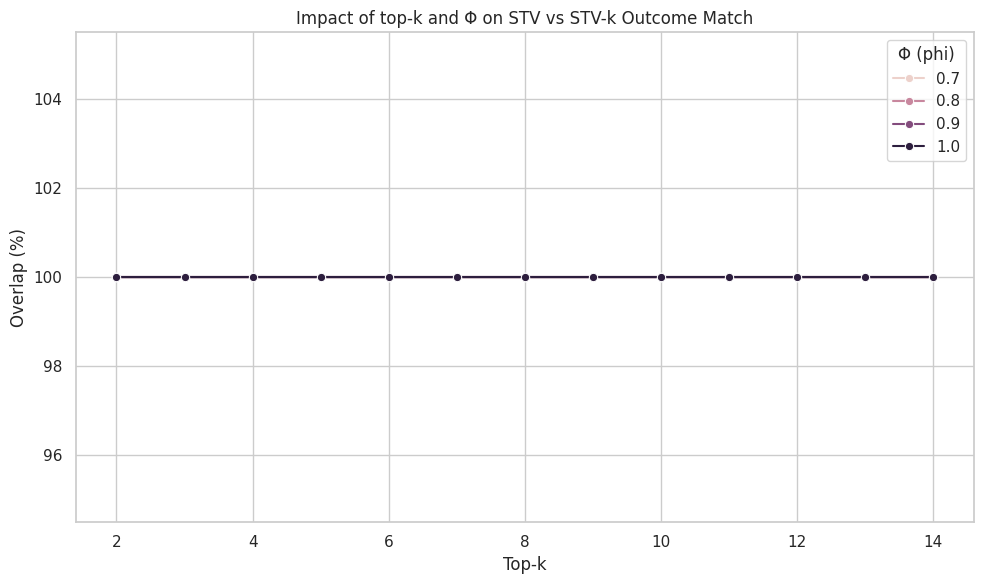

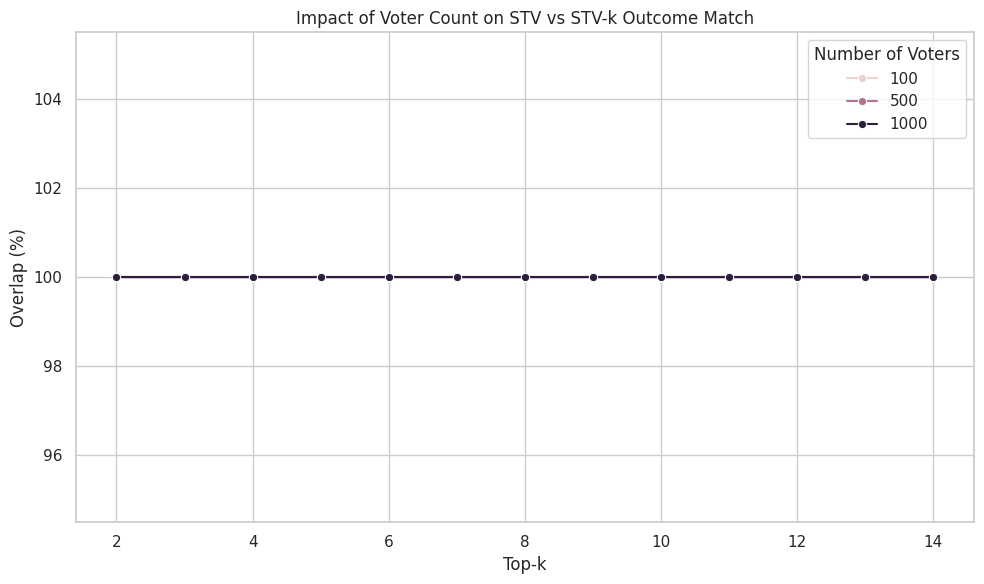

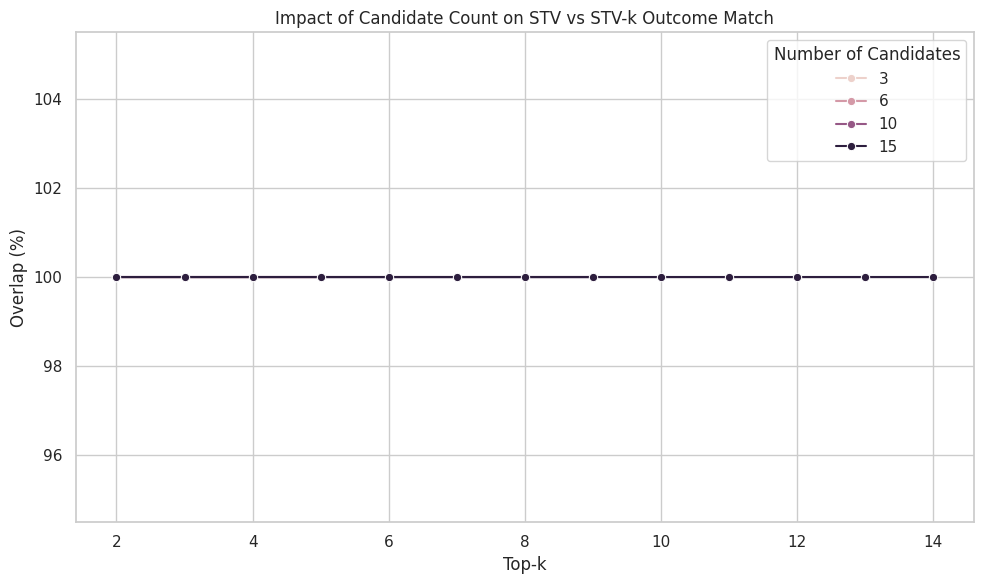

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("overlap_results.csv")

sns.set(style="whitegrid")

# PLOT 1: Overlap (%) as a function of top_k, for different Φ (phi) values
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="top_k", y="overlap_percent", hue="phi", marker="o")
plt.title("Impact of top-k and Φ on STV vs STV-k Outcome Match")
plt.xlabel("Top-k")
plt.ylabel("Overlap (%)")
plt.legend(title="Φ (phi)")
plt.tight_layout()
plt.savefig("overlap_by_topk_phi.png")
plt.show()

# PLOT 2: Overlap (%) as a function of top_k, for different numbers of voters
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="top_k", y="overlap_percent", hue="voters", marker="o")
plt.title("Impact of Voter Count on STV vs STV-k Outcome Match")
plt.xlabel("Top-k")
plt.ylabel("Overlap (%)")
plt.legend(title="Number of Voters")
plt.tight_layout()
plt.savefig("overlap_by_topk_voters.png")
plt.show()

# PLOT 3: Overlap (%) as a function of top_k, for different numbers of candidates
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="top_k", y="overlap_percent", hue="candidates", marker="o")
plt.title("Impact of Candidate Count on STV vs STV-k Outcome Match")
plt.xlabel("Top-k")
plt.ylabel("Overlap (%)")
plt.legend(title="Number of Candidates")
plt.tight_layout()
plt.savefig("overlap_by_topk_candidates.png")
plt.show()